In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
from sklearn import linear_model
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
from sklearn.cross_decomposition import PLSRegression

In [157]:
# Path to aligned data
# data_alingned_path = '/mnt/disk2/Arthur_data/B6J3217-2025-07-02T13-13-14_processedData/aligned_data/B6J3217_downsampled_data_Apply halt: 2s_aligned.csv'
data_alingned_path = '/mnt/disk2/Arthur_data/B6J2718-2024-12-10T12-57-02_processedData/aligned_data/B6J2718_downsampled_data_Apply halt_2s_aligned.csv'

data_aligned_csv = pd.read_csv(data_alingned_path)

# Creation of new column with index of each MM
halt_index = 0
halt_indices = []
prev_halt_time = None

for _, row in data_aligned_csv.iterrows():
    if row['Halt Time'] != prev_halt_time:
        halt_index += 1
        prev_halt_time = row['Halt Time']
    halt_indices.append(halt_index-1)

data_aligned_csv['halt_index'] = halt_indices

# Printing every column names to see every variables
col_names = data_aligned_csv.columns
print("\n".join(col_names))


Encoder
Position_0X
Position_0Y
CumulativeCounts_0X
CumulativeCounts_0Y
dfF_470
dfF_560
dfF_410
z_470
z_560
z_410
Photodiode_int
Encoder_Unwrapped
Motor_Velocity
Motor_Acceleration
Velocity_0X
Acceleration_0X
Velocity_0Y
Acceleration_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1
saccade_event_eye1
saccade_event_eye2
Time (s)
Halt Time
saccade_probability_eye1
halt_index


In [143]:
# Setting of the MM wanted for visualisation and annalysis
MM_id = 1
spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == MM_id]
print(spe_halt_data)

       Encoder  Position_0X  Position_0Y  CumulativeCounts_0X  \
16001  73.9978       7.7433   -8874.5622             975533.0   
16002  73.9988       7.7433   -8874.5623             975533.0   
16003  73.9997       7.7433   -8874.5623             975531.0   
16004  74.0006       7.7433   -8874.5621             975531.0   
16005  74.0015       7.7433   -8874.5619             975531.0   
...        ...          ...          ...                  ...   
31997  61.0146       8.3612   -8715.9640            1053603.0   
31998  61.0156       8.3613   -8715.9611            1053603.0   
31999  61.0166       8.3615   -8715.9580            1053603.0   
32000  61.0178       8.3617   -8715.9546            1053603.0   
32001  61.0191       8.3619   -8715.9509            1053603.0   

       CumulativeCounts_0Y  dfF_470  dfF_560  dfF_410   z_470   z_560  ...  \
16001           -1951374.0  -0.0040   0.9956   1.0117 -0.6572 -0.1130  ...   
16002           -1951374.0  -0.0042   0.9956   1.0117 -0.6939 -

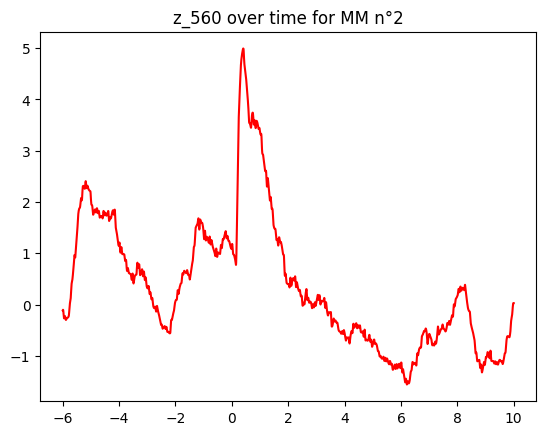

In [144]:
# Visualisation of the z score 560 for selected MM
plt.plot(spe_halt_data['Time (s)'], spe_halt_data['z_560'], color = 'red')
plt.title(f'z_560 over time for MM n°{MM_id+1}')
plt.show()

## Correlation 1v1 and correlation matrix

Correlation between z_560 and Position_0X: -0.5577391887661659


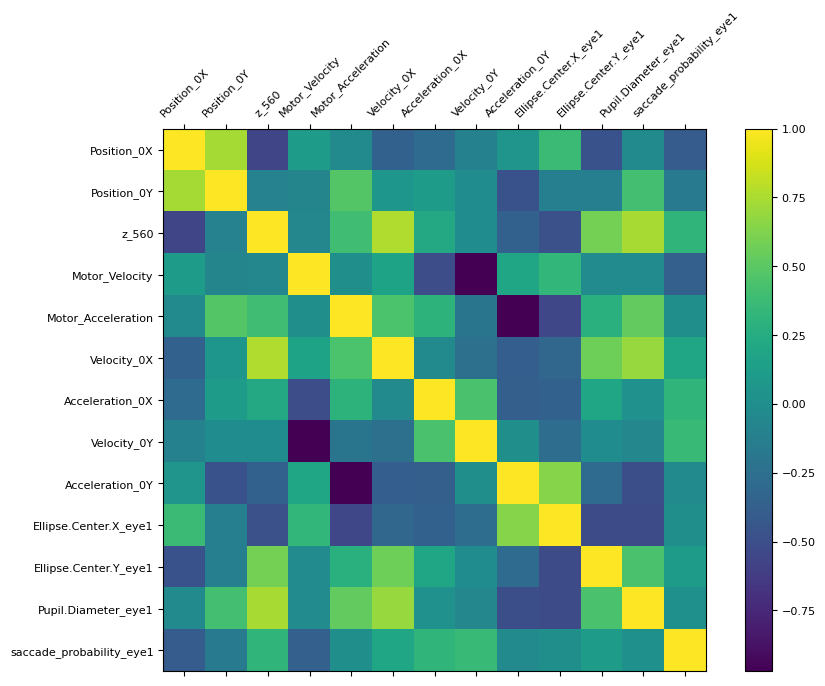

In [203]:
# red = gecko = 560 --> z_560 used for neural activity
# motor_velocity, velocity_0Y, Velocity_0X, saccade_probability_eye1, pupil (elipse ?) diameter

# The two features you want to see the correlation of
c1 = spe_halt_data['z_560']
c2 = spe_halt_data['Position_0X']
numpy_correlation = np.corrcoef(c1, c2)[0, 1]
print(f'Correlation between {c1.name} and {c2.name}:', numpy_correlation)

# Correlation matrix of all features minus what is specified line just below
spe_halt_data_no_bs = spe_halt_data.drop(['Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
f = plt.figure(figsize=(10, 7))
plt.matshow(spe_halt_data_no_bs.corr(), fignum=f.number)
plt.xticks(range(spe_halt_data_no_bs.shape[1]), spe_halt_data_no_bs.columns, fontsize=8, rotation=45)
plt.yticks(range(spe_halt_data_no_bs.shape[1]), spe_halt_data_no_bs.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.show()

In [146]:
x = np.column_stack([spe_halt_data['Motor_Velocity'], spe_halt_data['Velocity_0X'], spe_halt_data['Velocity_0Y'], spe_halt_data['Pupil.Diameter_eye1'], spe_halt_data['Ellipse.Center.X_eye1'], spe_halt_data['Ellipse.Center.Y_eye1']]) # , spe_halt_data['saccade_probability_eye1'], spe_halt_data['saccade_event_eye1']
y = spe_halt_data['z_560']

model = LinearRegression().fit(x, y)

print('multiple linear regression coef:', model.coef_) 
print('multiple linear regression R²:', model.score(x, y))

multiple linear regression coef: [-2.38445273e-02  1.04271682e+01 -2.36061451e-04  2.66986280e-01
 -1.11279801e-02  2.10992398e-01]
multiple linear regression R²: 0.7129442382267325


In [ ]:
# a = spe_halt_data.drop(['z_560', 'Halt Time'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
# b = spe_halt_data['z_560']

# scaler = StandardScaler()
# a_scaled = scaler.fit_transform(a)
# print(a_scaled)

# def compute_auc(ax2, ax1=spe_halt_data['Time (s)']):
#     if ax2 is None:
#         print('No variable mentionned. Please determine ax2')
#         return None
#     AUC = auc(ax1, ax2)
#     return AUC

# AUC = compute_auc(ax2=spe_halt_data['z_560'])
# print(AUC)

6.1049934499999985


## PCA : Whithout considering z_560, create new uncorrelated variables that explain the variance the most
## Detail features present in new principal components

In [152]:
# Keep only numeric columns
a = spe_halt_data.drop(['Time (s)', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
spe_halt_data_num = a.select_dtypes(include=[np.number])

# Target variable
target = "z_560"

# Drop rows with NaNs
spe_halt_data_num = spe_halt_data_num.dropna()

# Separate z_560
y = spe_halt_data_num[target].values
X = spe_halt_data_num.drop(columns=[target])

# Z-score variables
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(Xz)


explained_var = pca.explained_variance_ratio_

feature_names = X.columns

for pc_idx, (var, component) in enumerate(
        zip(pca.explained_variance_ratio_, pca.components_)):

    loadings = pd.Series(component, index=feature_names)

    # Sort by absolute loading
    loadings_sorted = loadings.reindex(
        loadings.abs().sort_values(ascending=False).index
    )

    print(f"\nPC{pc_idx+1}: {var*100:.2f}% variance explained")
    for feature, value in loadings_sorted.items():
        print(f"{feature:25s} {value:+.3f}")



PC1: 32.75% variance explained
Acceleration_0Y           +0.430
Motor_Acceleration        -0.410
Ellipse.Center.X_eye1     +0.405
Pupil.Diameter_eye1       -0.367
Velocity_0X               -0.323
Ellipse.Center.Y_eye1     -0.309
Acceleration_0X           -0.237
Position_0Y               -0.167
Position_0X               +0.162
Motor_Velocity            +0.147
saccade_probability_eye1  -0.108
Velocity_0Y               -0.074

PC2: 22.58% variance explained
Velocity_0Y               +0.521
Motor_Velocity            -0.491
saccade_probability_eye1  +0.336
Acceleration_0X           +0.324
Position_0X               -0.273
Position_0Y               -0.246
Motor_Acceleration        -0.211
Pupil.Diameter_eye1       -0.196
Velocity_0X               -0.179
Acceleration_0Y           +0.115
Ellipse.Center.X_eye1     -0.083
Ellipse.Center.Y_eye1     +0.017

PC3: 17.95% variance explained
Position_0X               +0.524
Position_0Y               +0.524
Ellipse.Center.Y_eye1     -0.345
Velocity_0X  

## PLS Regression : Which features explain variance in X that is also predictive of y

In [205]:
pls = PLSRegression(n_components=5)
pls.fit(Xz, y)

pls_loadings = pd.Series(pls.x_weights_[:,0], index=X.columns)
pls_loadings.sort_values(key=np.abs, ascending=False)

Velocity_0X                 0.487568
Pupil.Diameter_eye1         0.470345
Ellipse.Center.Y_eye1       0.375133
Position_0X                -0.354827
Ellipse.Center.X_eye1      -0.304622
Motor_Acceleration          0.252054
Acceleration_0Y            -0.230463
saccade_probability_eye1    0.201222
Acceleration_0X             0.138931
Position_0Y                -0.061854
Motor_Velocity             -0.035979
Velocity_0Y                -0.008660
dtype: float64

## Correlation of each PC with target z_560

In [204]:
pc_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

pc_y_corr = pc_df.apply(lambda pc: np.corrcoef(pc, y)[0,1])

print(f'\n{pc_y_corr}')



PC1    -0.696126
PC2     0.009740
PC3    -0.465344
PC4     0.269816
PC5     0.016507
PC6    -0.011478
PC7    -0.262590
PC8    -0.040652
PC9     0.157379
PC10    0.015028
PC11   -0.027594
PC12    0.127977
dtype: float64


## Ridge Regression

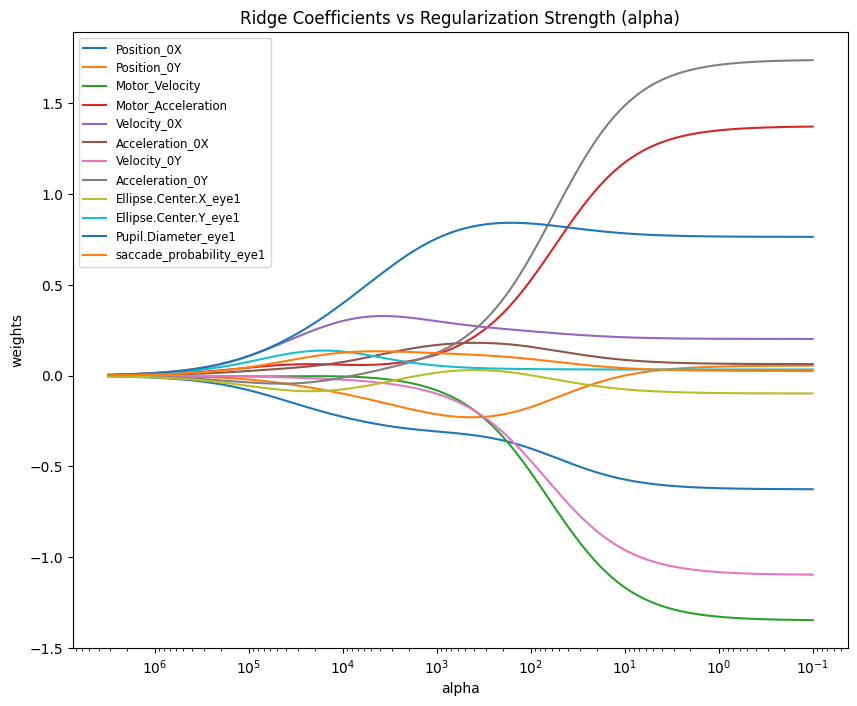

In [260]:
n_alphas = 200
alphas = np.logspace(-1, 6.5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xz, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.axis("tight")
plt.legend(
    [feature_names[i] for i in range(X.shape[1])], loc="upper left", fontsize="small"
)
plt.show()